### Price vs RSI

tl;dr
1. This cannot help one to decide when to sell a stock.
2. Based on history data, see how the price vary with respect to recent prices while RSI > 70.

Assumption:
1. The stock is good such that it is capable to raise (RSI > 70 sometimes).

In [1]:
# !pip install yfinance
# !pip install matplotlib
# !pip install panda

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### Definition:

Relative Strength Index
$$\text{RSI} = 100 - \frac{100}{1 + \text{RS}}$$

Relative Strength
$$\text{RS} = \frac{average\ gain\ over\ a\ period}{average\ loss\ over\ the\ same\ period}$$

average gain over a period = sum of gains in price over the period divide by number of gain days

average loss over a period = sum of losses in price over the period divide by number of loss days

The period is typically 14 days.

For example,
1. $\text{RSI} = 0$ if no gain and all loss during the period.
2. $\text{RSI} = 0.5$, e.g. 1 day gain \$1 and 13 days loss \$1, i.e. the net gain in the period is -\$12. Also, if 13 days gain \$1 and 1 day loss \$1 (net gain +\$12).
3. $\text{RSI} = 1$ if all gain and no loss during the period.

In [3]:
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def prepare_df(ticker, days=0, start_date='2024-09-01', end_date='2025-08-31'):
    if days > 0:
        df = yf.download(ticker, period=f'{days}d', auto_adjust=True, progress=False)
    else:
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)
    df['RSI'] = calculate_rsi(df['Close'])
    return df

#### Prepare data

Plot AAPL Close Price and RSI

In [4]:
df_aapl = prepare_df('AAPL')

In [5]:
def plot_price_rsi(df):
    fig, ax1 = plt.subplots()
    ax1.plot(df.index, df['Close'], label='Close Price', color='blue')
    x_interval = int(len(df) / 21 / 10)
    if x_interval == 0:
        x_interval = 1
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=x_interval))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    ax1.set_ylabel('Close Price', color='blue')
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['RSI'], label='RSI', color='g')
    ax2.set_ylabel('RSI', color='g')
    ax2.axhline(y=70, color='g', linestyle='-', label='RSI 70')
    ax2.axhline(y=30, color='g', linestyle='-', label='RSI 30')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper right')
    plt.show()

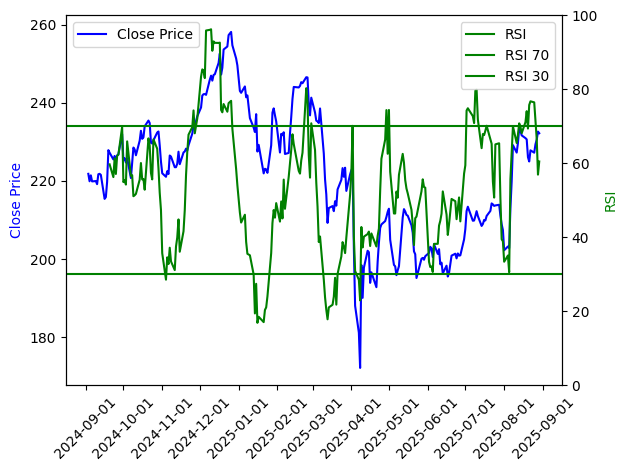

In [6]:
plot_price_rsi(df_aapl)

<img src="https://upload.wikimedia.org/wikipedia/commons/d/db/The_Magnificent_Seven_cast_publicity_photo.jpg" alt="magnificent 7" width="400">

In [7]:
SYMBOLS = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
df_m7 = {}
for symbol in SYMBOLS:
    df_m7[symbol] = prepare_df(symbol, start_date='2022-09-01', end_date='2025-08-31')  # 3 years data

#### Approach 1. Find RSI just before drop below 70. Compare the Close Price to max price around (e.g. -2 to +10 days)

Look at history data.  Find the Close Price on the last day of consecutive RSI >= 70 and the next day.  Compare them to the recently maximumn price, minimum price and average price.

In [8]:
LEFT_MIN = 21       # trade days per month
LEFT_AVERAGE = 21
LEFT_MAX = 2        # arbitrary take
RIGHT_MAX = 10      # arbitrary take

In [9]:
def get_price_average(df, start_index, end_index):
    return df.iloc[start_index:end_index]['Close'].mean().iloc[-1]

def get_price_min(df, start_index, end_index):
    return df.iloc[start_index:end_index]['Close'].min().iloc[-1]

def get_price_max(df, start_index, end_index):
    return df.iloc[start_index:end_index]['Close'].max().iloc[-1]


In [10]:
df_aapl_5_7 = df_aapl['2025-05-01':'2025-07-31']
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
print(df_aapl_5_7['2025-07-08':'2025-07-18'])
pd.reset_option('display.max_rows')
pd.reset_option('display.expand_frame_repr')

Price            Close        High         Low        Open    Volume        RSI
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL           
Date                                                                           
2025-07-08  209.771927  211.190315  208.213698  209.861836  42848900  70.792926
2025-07-09  210.900650  211.090437  206.985096  209.292475  48749400  79.557553
2025-07-10  212.169205  213.237984  209.791898  210.271350  44443600  79.811635
2025-07-11  210.920624  211.889525  209.622094  210.331296  39765800  71.727942
2025-07-14  208.383499  210.670912  207.304722  209.692012  38840100  64.004690
2025-07-15  208.872955  211.649803  208.683168  208.982831  42296300  67.826766
2025-07-16  209.921768  212.159219  208.403487  210.061609  47490500  67.550996
2025-07-17  209.781921  211.559902  209.352401  210.331301  48068100  68.729212
2025-07-18  210.940598  211.549907  209.462280  210.630951  48974600  70.071505


Illustrate recently minimum price, average price, maximum price in a chart.

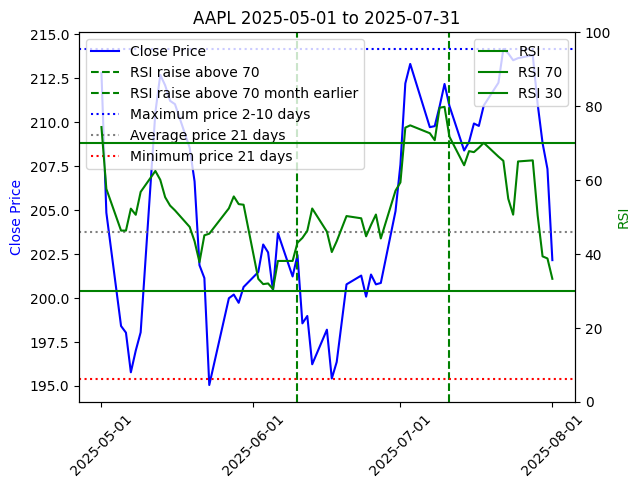

price min: 195.42, price average: 203.76, price max: 214.16
price close on 2025-07-11: 210.92, on next trade day: 208.38


In [11]:
# RSI just above 70 on 2025-07-11 and drop below 70 on 2025-07-14 (next trade day)
EVENT_DATE_STR = '2025-07-11'
df_aapl_5_7 = df_aapl['2025-05-01':'2025-08-01']
fig, ax1 = plt.subplots()
plt.title('AAPL 2025-05-01 to 2025-07-31')
ax1.plot(df_aapl_5_7.index, df_aapl_5_7['Close'], label='Close Price', color='blue')
event_date = pd.to_datetime(EVENT_DATE_STR)
event_date_month_earlier = df_aapl_5_7.index[df_aapl_5_7.index.get_loc(EVENT_DATE_STR) - LEFT_MIN]
ax1.axvline(x=event_date, color='g', linestyle='--', label='RSI raise above 70')
ax1.axvline(x=event_date_month_earlier, color='g', linestyle='--', label='RSI raise above 70 month earlier')
price_min = get_price_min(df_aapl_5_7, df_aapl_5_7.index.get_loc(EVENT_DATE_STR) - LEFT_MIN, df_aapl_5_7.index.get_loc(EVENT_DATE_STR) + 1)
price_average = get_price_average(df_aapl_5_7, df_aapl_5_7.index.get_loc(EVENT_DATE_STR) - LEFT_AVERAGE, df_aapl_5_7.index.get_loc(EVENT_DATE_STR) + 1)
price_max = get_price_max(df_aapl_5_7, df_aapl_5_7.index.get_loc(EVENT_DATE_STR) - LEFT_MAX, df_aapl_5_7.index.get_loc(EVENT_DATE_STR) + RIGHT_MAX + 1)
ax1.axhline(y=price_max, color='b', linestyle=':', label=f'Maximum price {LEFT_MAX}-{RIGHT_MAX} days')
ax1.axhline(y=price_average, color='grey', linestyle=':', label=f'Average price {LEFT_AVERAGE} days')
ax1.axhline(y=price_min, color='r', linestyle=':', label=f'Minimum price {LEFT_MIN} days')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
ax1.set_ylabel('Close Price', color='blue')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(df_aapl_5_7.index, df_aapl_5_7['RSI'], label='RSI', color='g')
ax2.set_ylabel('RSI', color='g')
ax2.axhline(y=70, color='g', linestyle='-', label='RSI 70')
ax2.axhline(y=30, color='g', linestyle='-', label='RSI 30')
ax2.set_ylim(0, 100)
ax2.legend(loc='upper right')
plt.show()
print(f'price min: {price_min:.2f}, price average: {price_average:.2f}, price max: {price_max:.2f}')
print('price close on {}: {:.2f}, on next trade day: {:.2f}'.format(
    EVENT_DATE_STR, 
    df_aapl_5_7.iloc[df_aapl_5_7.index.get_loc(EVENT_DATE_STR)].iloc[0], 
    df_aapl_5_7.iloc[df_aapl_5_7.index.get_loc(EVENT_DATE_STR) + 1].iloc[0]))

Above figure,
1. Area between 2 green dash vertical lines are used to calculate the price minimum and price average before RSI raises above 70 on 2025-07-02.
2. Dot red horizontal line is price minimum
3. Dot grey horizontal line is price average
4. Dot blue horizontal line is price maximum between 2025-07-02 -2 days and +10 days

One can visualize the Close Price around 2025-07-02 with respect to the dot horizontal lines.

In [12]:
def find_price_when_rsi_drop_below_70(df, printout=False):
    index_close = df.columns.get_loc('Close').start
    index_rsi = df.columns.get_loc('RSI').start

    # skip beginning until RSI < 70
    for i_skip, row in df.iterrows():
        if row.iloc[index_rsi] < 70:
            break
    
    count = 0
    price_div_max_sum = 0
    price_next_div_max_sum = 0
    price_div_min_sum = 0
    price_next_div_min_sum = 0
    price_div_average_sum = 0
    price_next_div_average_sum = 0
    if printout:
        print('count, date, price, price_next, price_min, price_average, price_max, price/max, price_next/max')
    for i, row in df[df.index.get_loc(i_skip):-1].iterrows():   # loop from i_skip to 2nd last row
        iloc_index = df.index.get_loc(i)
        if row.iloc[index_rsi] >= 70 and df.iloc[iloc_index+1].iloc[index_rsi] < 70:
            count += 1
            price = row.iloc[index_close]                           # price on date RSI >= 70
            price_next = df.iloc[iloc_index+1].iloc[index_close]    # price on next date RSI < 70
            price_min = get_price_min(df, iloc_index - LEFT_MIN, iloc_index + 1)
            price_average = get_price_average(df, iloc_index - LEFT_AVERAGE, iloc_index + 1)
            price_max = get_price_max(df, iloc_index - LEFT_MAX, iloc_index + RIGHT_MAX + 1)
            
            price_div_max_sum += price / price_max                  # the closer to 1, the better the price 
            price_next_div_max_sum += price_next / price_max        # similar for next trade day price

            price_div_min_sum += price / price_min
            price_next_div_min_sum += price_next / price_min

            price_div_average_sum += price / price_average
            price_next_div_average_sum += price_next / price_average

            if printout:
                print('{}, {}'.format(count, i.strftime('%Y-%m-%d')), end='')
                print(f', {price:.2f}, {price_next:.2f}, {price_min:.2f}, {price_average:.2f}, {price_max:.2f}', end='')
                print(f', {price / price_max:.2f}, {price_next / price_max:.2f}')
    return (price_div_max_sum / count, price_next_div_max_sum / count, 
            price_div_min_sum / count, price_next_div_min_sum / count, 
            price_div_average_sum / count, price_next_div_average_sum / count)

In [13]:
find_price_when_rsi_drop_below_70(df_m7['AAPL'], printout=True)

count, date, price, price_next, price_min, price_average, price_max, price/max, price_next/max
1, 2023-02-08, 149.81, 148.77, 128.34, 139.78, 153.40, 0.98, 0.97
2, 2023-03-22, 155.87, 156.96, 143.51, 149.48, 164.11, 0.95, 0.96
3, 2023-04-04, 163.58, 161.73, 146.66, 155.04, 165.55, 0.99, 0.98
4, 2023-04-06, 162.62, 160.02, 146.66, 156.07, 165.55, 0.98, 0.97
5, 2023-05-02, 166.45, 165.37, 158.11, 163.35, 171.60, 0.97, 0.96
6, 2023-06-05, 177.60, 177.23, 163.73, 172.23, 183.96, 0.97, 0.96
7, 2023-06-20, 182.97, 181.93, 169.67, 176.98, 191.83, 0.95, 0.95
8, 2023-07-03, 190.34, 189.22, 175.86, 182.62, 191.85, 0.99, 0.99
9, 2023-07-17, 191.85, 191.59, 181.92, 186.63, 194.28, 0.99, 0.99
10, 2023-07-31, 194.28, 193.45, 186.00, 190.23, 194.28, 1.00, 1.00
11, 2023-09-05, 187.86, 181.14, 172.31, 178.41, 187.86, 1.00, 0.96
12, 2023-11-10, 184.84, 183.25, 165.27, 174.41, 189.84, 0.97, 0.97
13, 2023-11-28, 188.80, 187.78, 166.59, 181.69, 194.07, 0.97, 0.97
14, 2023-11-30, 188.36, 189.63, 169.11, 183

(np.float64(0.9771167972138656),
 np.float64(0.9655376443871927),
 np.float64(1.1108624185709974),
 np.float64(1.0979195575911498),
 np.float64(1.0431733097651321),
 np.float64(1.0310402564734864))

In [14]:
print('Find RSI just before drop below 70')
print('ticker \tp/max \tpn/max \tp/min \tpn/min \tp/avg \tpn/avg')
for symbol in SYMBOLS:
    ret = find_price_when_rsi_drop_below_70(df_m7[symbol], printout=False)
    print(f'{symbol} \t{ret[0]:.2f} \t{ret[1]:.2f} \t{ret[2]:.2f} \t{ret[3]:.2f} \t{ret[4]:.2f} \t{ret[5]:.2f}')

Find RSI just before drop below 70
ticker 	p/max 	pn/max 	p/min 	pn/min 	p/avg 	pn/avg
AAPL 	0.98 	0.97 	1.11 	1.10 	1.04 	1.03
AMZN 	0.98 	0.96 	1.14 	1.12 	1.06 	1.04
GOOG 	0.98 	0.96 	1.13 	1.12 	1.06 	1.04
META 	0.95 	0.94 	1.16 	1.15 	1.06 	1.05
MSFT 	0.98 	0.96 	1.11 	1.10 	1.05 	1.04
NVDA 	0.93 	0.91 	1.26 	1.24 	1.11 	1.09
TSLA 	0.95 	0.92 	1.31 	1.27 	1.12 	1.09


p/max is price on last RSI >= 70 divide by recently maximum price.

pn/max is price on the next day (i.e. RS drops below 70) divide by recently maximum price.

Similarly for the p/min, pn/min, p/avg and pn/avg.

Some observations:
1. AAPL p/max is close to 1. However, the gain from p/avg is not impressive.
2. TSLA p/max 0.95 means price on last RSI >= 70 is comparsively less than maximum price. p/avg means significant gain from recently average. 

#### Approach 2. Consider the price when RSI raise above 70

It may be difficult to predict if RSI is just before drop below 70.  As a alternative, can we use the event RSI just raise above 70?

Find RSI raise above 70. Compare the Close Price on this day (day 1) to max price around.  Repeat for day 2 etc while RSI is still above 70.  It is unlikely to sell on day 1. As RSI on day 1 is known, one may sell on day 2 or onward.

In [15]:
def find_price_when_rsi_raise_above_70(df, printout=False):
    index_close = df.columns.get_loc('Close').start
    index_rsi = df.columns.get_loc('RSI').start

    # skip beginning until RSI < 70
    for i_skip, row in df.iterrows():
        if row.iloc[index_rsi] < 70:
            break
    
    count = 0
    consecutive_days = 0
    price_div_max_sum = 0
    price_next_div_max_sum = 0
    price_div_min_sum = 0
    price_next_div_min_sum = 0
    price_div_average_sum = 0
    price_next_div_average_sum = 0
    if printout:
        print('count, consecutive_days, date, price, price_min, price_average, price_max, price/max')
    for i, row in df[df.index.get_loc(i_skip):].iterrows(): 
        iloc_index = df.index.get_loc(i)
        if row.iloc[index_rsi] >= 70:
            if consecutive_days == 0:
                count += 1
            consecutive_days += 1
            
            price = row.iloc[index_close]
            price_min = get_price_min(df, iloc_index - LEFT_MIN, iloc_index + 1)
            price_average = get_price_average(df, iloc_index - LEFT_AVERAGE, iloc_index + 1)
            price_max = get_price_max(df, iloc_index - LEFT_MAX, iloc_index + RIGHT_MAX + 1)
            
            # printout may be used for speadsheet 
            if printout:
                print('{}, {}, {}'.format(count, consecutive_days, i.strftime('%Y-%m-%d')), end='')
                print(f', {price:.2f}, {price_min:.2f}, {price_average:.2f}, {price_max:.2f}', end='')
                print(f', {price / price_max:.2f}')

            # calculate day 1 and next day price divide by recent min, average and max
            if consecutive_days == 1: 
                price_next = df.iloc[iloc_index+1].iloc[index_close]
                
                price_div_max_sum += price / price_max
                price_next_div_max_sum += price_next / price_max

                price_div_min_sum += price / price_min
                price_next_div_min_sum += price_next / price_min
                
                price_div_average_sum += price / price_average
                price_next_div_average_sum += price_next / price_average
        else:
            consecutive_days = 0
            
    return (price_div_max_sum / count, price_next_div_max_sum / count, 
            price_div_min_sum / count, price_next_div_min_sum / count, 
            price_div_average_sum / count, price_next_div_average_sum / count)


In [16]:
find_price_when_rsi_raise_above_70(df_m7['AAPL'], printout=True)

count, consecutive_days, date, price, price_min, price_average, price_max, price/max
1, 1, 2023-01-23, 139.15, 123.28, 130.05, 152.35, 0.91
1, 2, 2023-01-24, 140.55, 123.28, 130.51, 152.50, 0.92
1, 3, 2023-01-25, 139.89, 123.28, 130.80, 152.50, 0.92
1, 4, 2023-01-26, 141.96, 123.28, 131.32, 152.50, 0.93
1, 5, 2023-01-27, 143.90, 123.28, 131.95, 152.50, 0.94
1, 6, 2023-01-30, 141.01, 123.28, 132.53, 152.50, 0.92
1, 7, 2023-01-31, 142.28, 123.28, 133.35, 152.50, 0.93
1, 8, 2023-02-01, 143.41, 123.28, 134.06, 153.40, 0.93
1, 9, 2023-02-02, 148.72, 123.28, 135.00, 153.40, 0.97
1, 10, 2023-02-03, 152.35, 123.28, 136.32, 153.40, 0.99
1, 11, 2023-02-06, 149.62, 123.28, 137.45, 153.40, 0.98
1, 12, 2023-02-07, 152.50, 127.82, 138.78, 153.40, 0.99
1, 13, 2023-02-08, 149.81, 128.34, 139.78, 153.40, 0.98
2, 1, 2023-03-21, 157.30, 143.51, 149.24, 164.11, 0.96
2, 2, 2023-03-22, 155.87, 143.51, 149.48, 164.11, 0.95
3, 1, 2023-03-29, 158.78, 143.51, 151.93, 164.11, 0.97
3, 2, 2023-03-30, 160.35, 143.5

(np.float64(0.9724625620966885),
 np.float64(0.9679688477961771),
 np.float64(1.1091170365185699),
 np.float64(1.1042439635878911),
 np.float64(1.0454787775799832),
 np.float64(1.0409703160153478))

In [17]:
print('Consider the price when RSI raise above 70')
print('ticker \tp/max \tpn/max \tp/min \tpn/min \tp/avg \tpn/avg')
for symbol in SYMBOLS:
    ret = find_price_when_rsi_raise_above_70(df_m7[symbol])
    print(f'{symbol} \t{ret[0]:.2f} \t{ret[1]:.2f} \t{ret[2]:.2f} \t{ret[3]:.2f} \t{ret[4]:.2f} \t{ret[5]:.2f}')

Consider the price when RSI raise above 70
ticker 	p/max 	pn/max 	p/min 	pn/min 	p/avg 	pn/avg
AAPL 	0.97 	0.97 	1.11 	1.10 	1.05 	1.04
AMZN 	0.97 	0.97 	1.13 	1.12 	1.06 	1.06
GOOG 	0.97 	0.97 	1.12 	1.13 	1.06 	1.06
META 	0.95 	0.95 	1.16 	1.16 	1.07 	1.07
MSFT 	0.97 	0.97 	1.10 	1.11 	1.05 	1.05
NVDA 	0.91 	0.92 	1.25 	1.26 	1.11 	1.12
TSLA 	0.91 	0.92 	1.29 	1.29 	1.12 	1.13


Observations:
1. Overall results are similar to the approach 1. Many of the entries of approach 1 and 2 are within 1%.
2. As approach 1, pn (price on next day is more practical to capture) and have similar values of the p results.

In [18]:
pd.__version__

'2.3.2'

In [19]:
yf.__version__

'0.2.65'